In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from pushover import notify
from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
bs = 32 # batchsize

In [20]:
# Load Data
dataset = datasets.ImageFolder(root='trainings/faces', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)

(2515, 79)

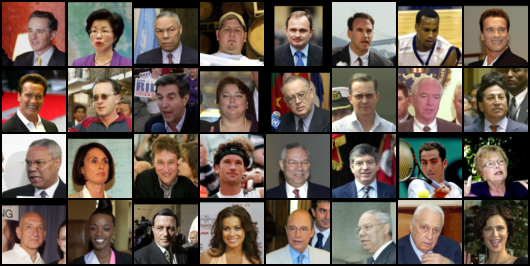

In [21]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'outputs/real_image.png')

Image('outputs/real_image.png')

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [8]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [9]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [10]:
image_channels = fixed_x.size(1)

In [11]:
vae = VAE(image_channels=image_channels).to(device)
# model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

In [12]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [13]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [15]:
epochs = 50

In [16]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
#                                 epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.data/bs, bce.data/bs, kld.data/bs)
    print(to_print)

# notify to android when finished training
notify(to_print, priority=1)

/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/50] Loss: 4490.779 4490.733 0.046
Epoch[2/50] Loss: 4014.194 4014.073 0.121
Epoch[3/50] Loss: 4076.463 4076.332 0.131
Epoch[4/50] Loss: 3819.663 3819.510 0.152
Epoch[5/50] Loss: 4060.466 4060.318 0.149
Epoch[6/50] Loss: 3647.638 3647.454 0.184
Epoch[7/50] Loss: 4054.768 4054.602 0.166
Epoch[8/50] Loss: 3925.399 3925.238 0.161
Epoch[9/50] Loss: 4002.782 4002.619 0.163
Epoch[10/50] Loss: 3764.956 3764.784 0.172
Epoch[11/50] Loss: 3749.815 3749.638 0.177
Epoch[12/50] Loss: 3949.506 3949.324 0.182
Epoch[13/50] Loss: 4011.627 4011.469 0.158
Epoch[14/50] Loss: 3820.916 3820.722 0.193
Epoch[15/50] Loss: 3777.122 3776.922 0.201
Epoch[16/50] Loss: 3746.597 3746.393 0.205
Epoch[17/50] Loss: 4033.305 4033.146 0.159
Epoch[18/50] Loss: 3662.698 3662.497 0.201
Epoch[19/50] Loss: 3545.467 3545.245 0.223
Epoch[20/50] Loss: 3891.436 3891.243 0.193
Epoch[21/50] Loss: 4025.791 4025.610 0.181
Epoch[22/50] Loss: 3693.661 3693.457 0.204
Epoch[23/50] Loss: 4014.035 4013.855 0.180
Epoch[24/50] Loss: 3

In [18]:
torch.save(vae.state_dict(), 'models/vae.torch-AC-nimgs_{}-epochs_{}'.format(len(dataset.imgs), epochs))